# Skin Lesion classification using deep learning

## Importing libraries

In [19]:
# Graph plotting

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


# data manipulation
import numpy as np
import pandas as pd
import os
from glob import glob
import shutil
import gc

np.random.seed(23)

# sci-kit learn tools
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

#deep learning models and tools
import keras
import tensorflow as tf
from keras import layers
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input
from tensorflow.keras.applications import EfficientNetB2
from keras import backend as K
# from keras.layers.Normalization import 
from keras.optimizers import Adam, Adamax
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Importing dataset

In [20]:
base_dir = os.path.join('..', 'input','skin-cancer-mnist-ham10000') # Merging images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x 
                     for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [21]:
meta_df = pd.read_csv(os.path.join(base_dir,'HAM10000_metadata.csv'))
meta_df['path'] = meta_df['image_id'].map(imageid_path_dict.get)
meta_df['cell_type'] = meta_df['dx'].map(lesion_type_dict.get) 
meta_df['cell_type_idx'] = pd.Categorical(meta_df['cell_type']).codes
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


## Pre-processing

In [22]:
# checking nulls
meta_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [23]:
meta_df['age'].fillna(meta_df.groupby("dx")['age'].transform(lambda x: x.fillna(x.mean())), inplace=True)

/tmp/ipykernel_611/80061188.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  meta_df['age'].fillna(meta_df.groupby("dx")['age'].transform(lambda x: x.fillna(x.mean())), inplace=True)


In [24]:
meta_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [25]:
meta_df.dtypes

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object

## Exploratory Data Analysis

<Axes: xlabel='cell_type'>

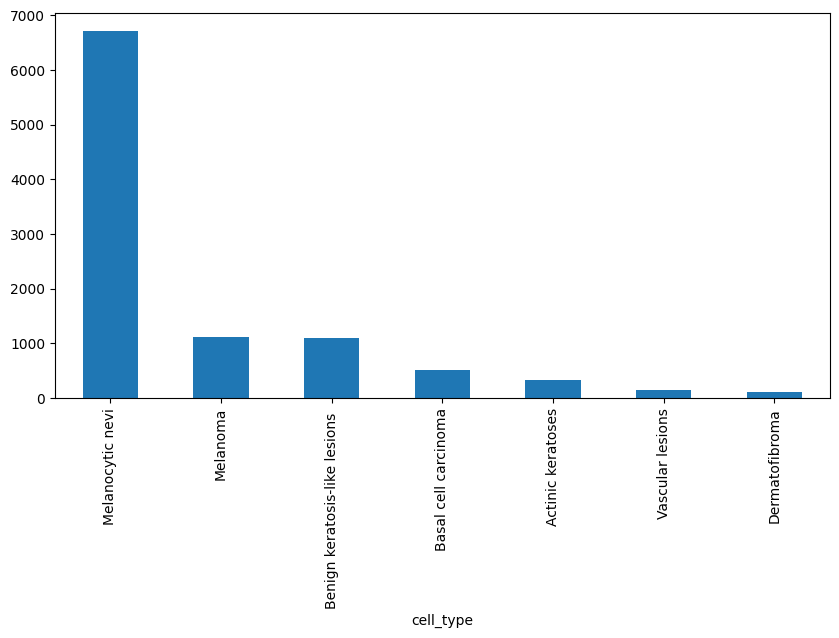

In [26]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
meta_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

<Axes: xlabel='dx_type'>

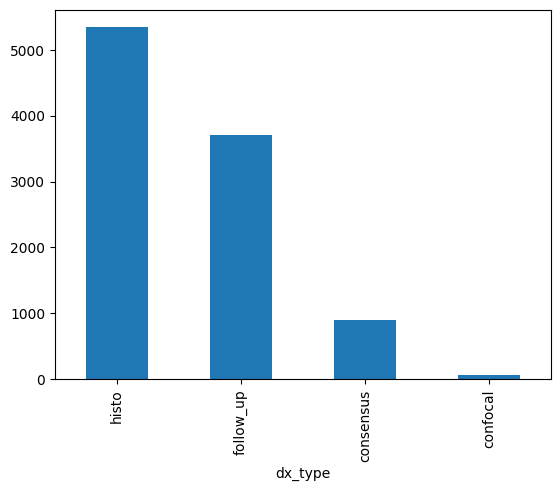

In [27]:
meta_df['dx_type'].value_counts().plot(kind='bar')

<Axes: xlabel='localization'>

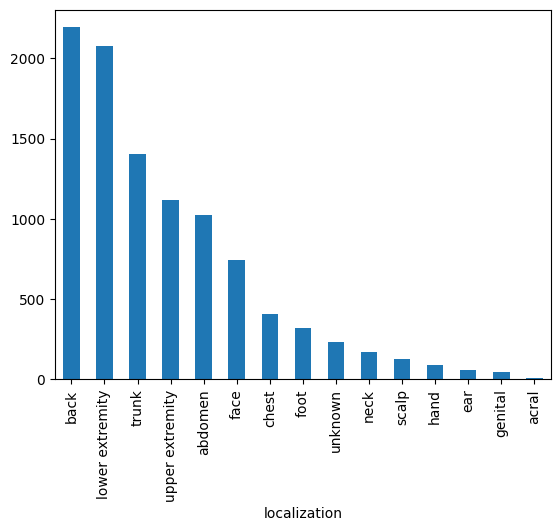

In [28]:
meta_df['localization'].value_counts().plot(kind='bar')

In [29]:
meta_df['age'].hist(bins=40)


KeyboardInterrupt



Error in callback <function flush_figures at 0x7a25a2ab25f0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [ ]:
meta_df['sex'].value_counts().plot(kind='bar')

In [ ]:
sns.boxplot(data=meta_df,y='age',x='cell_type_idx')

In [ ]:
fig, ax = plt.subplots(figsize=[20,5])
sns.boxplot(data=meta_df,y='age',x='cell_type')

## Loading of images

In [ ]:
t_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(t_split.split(meta_df['path'], meta_df['dx']))
x_train, x_test_meta = meta_df['path'].iloc[train_index], meta_df['path'].iloc[test_index]
y_train, y_test_meta = meta_df['dx'].iloc[train_index], meta_df['dx'].iloc[test_index]

v_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=25)
train_index, val_index = next(v_split.split(x_train, y_train))
x_train, x_val_meta = x_train.iloc[train_index], x_train.iloc[val_index]
y_train, y_val_meta = y_train.iloc[train_index], y_train.iloc[val_index]


In [ ]:
if(os.path.exists('aug_dir')):
    shutil.rmtree('aug_dir')
if(os.path.exists('base_dir')):
    shutil.rmtree('base_dir')

In [ ]:
class_list = ['mel','bkl','bcc','akiec','vasc','df', 'nv']
train_dir = os.path.join('base_dir','train_dir')
val_dir = os.path.join('base_dir','validate_dir')
test_dir = os.path.join('base_dir','test_dir')

In [ ]:
os.makedirs(train_dir)
os.makedirs(val_dir)
os.makedirs(test_dir)


for cat in class_list:
    train_data_dir = os.path.join(train_dir, cat)
    os.mkdir(train_data_dir)
    val_data_dir = os.path.join(val_dir, cat)
    os.mkdir(val_data_dir)
    test_data_dir = os.path.join(test_dir, cat)
    os.mkdir(test_data_dir)
    

def categorical_storing(row, dataset_type):
    label = row['dx']    
    # source path to image
    src = row['path']
    fname = os.path.basename(src)
    if dataset_type == 'train':
        dst = os.path.join(train_dir, label, fname)    
        # copy the image from the source to the destination
        _ = shutil.copyfile(src, dst)
    elif dataset_type == 'test':
        dst = os.path.join(test_dir, label, fname)    
        # copy the image from the source to the destination
        _ = shutil.copyfile(src, dst)
    else:
        dst = os.path.join(val_dir, label, fname)    
        # copy the image from the source to the destination
        _ = shutil.copyfile(src, dst)

In [ ]:
pd.concat([x_train, y_train], axis=1).apply(lambda row: categorical_storing(row, dataset_type='train'),axis=1)
pd.concat([x_val_meta, y_val_meta], axis=1).apply(lambda row: categorical_storing(row, dataset_type='val'),axis=1)
pd.concat([x_test_meta, y_test_meta], axis=1).apply(lambda row: categorical_storing(row, dataset_type='test'),axis=1)

In [ ]:
def read_image(img_name,path):
#     print(img_name)
    image = tf.io.read_file(os.path.join(path,img_name))
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [150, 200])
    image = tf.image.per_image_standardization(image)
    return image
def save_images(row, path):
    global i
#     print(row)
    im =tf.io.encode_jpeg(tf.image.convert_image_dtype(row['images'], dtype=tf.uint8))
    tf.io.write_file(os.path.join(path,f'augmented_{i}.jpg'),im)
    i+=1
def batch_generator(df, num_batch):
    batches = np.array_split(np.arange(len(df)), num_batch)
    for batch in batches:
        yield df.iloc[batch]

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.3),
    layers.RandomTranslation(0.2,0.2)
])
batch_size = 100

if(os.path.exists('aug_dir')):
    shutil.rmtree('aug_dir')
aug_dir = 'aug_dir'
os.mkdir(aug_dir)
i = 0

for img_class in class_list:
    i=0
    src_path = os.path.join(train_dir,img_class)
    save_path = os.path.join(aug_dir,img_class)
    os.mkdir(save_path)
    images_df = pd.DataFrame({'path': os.listdir(src_path)})
#     images_df = images_df.map(lambda x: read_image(x,path=src_path))
    images_df = pd.DataFrame({'images':map(lambda x: np.asarray(Image.open(os.path.join(src_path,x)).resize((150,200)))/255, images_df['path'])})
#     images_df = tf.data.Dataset.from_tensor_slices(images_df.to_dict('list'))
#     images_df = images_df.shuffle(1000)
#     images_df = images_df.batch(batch_size)
    num_aug_images_wanted = 6000
    num_files = len(os.listdir(src_path))
    print(num_files)
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))
    print(num_batches)
#     print(save_path)
#     print(src_path)
    print("transforming:",img_class)
    for batch in batch_generator(images_df,num_batches):
        num_images = 0
        while num_images < batch_size:
            images_df = batch.map(lambda x: (data_augmentation(x, training=True)))
            num_images += len(images_df)
            images_df.iloc[:batch_size].apply(lambda row: save_images(row, path = save_path),axis=1)

In [ ]:
for img_class in class_list:
    for fname in os.listdir(os.path.join(aug_dir, img_class)):
        src = os.path.join(aug_dir, img_class,fname)
        dst = os.path.join(train_dir, img_class, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [ ]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

In [ ]:
print(len(os.listdir('aug_dir/nv')))
print(len(os.listdir('aug_dir/mel')))
print(len(os.listdir('aug_dir/bkl')))
print(len(os.listdir('aug_dir/bcc')))
print(len(os.listdir('aug_dir/akiec')))
print(len(os.listdir('aug_dir/vasc')))
print(len(os.listdir('aug_dir/df')))

In [ ]:
data_df = pd.DataFrame(columns=['images','dx'])
for img_class in class_list:
    path = os.path.join(train_dir,img_class)
    files = os.listdir(path)
    temp_df = pd.DataFrame({'images':list(map(lambda x: np.asarray(Image.open(os.path.join(path,x)).resize((60,80)))/255.0,files)), 'dx':[img_class]*len(files)})
    data_df = pd.concat([data_df, temp_df])

In [ ]:
val_df = pd.DataFrame(columns=['images','dx'])
for img_class in class_list:
    path = os.path.join(val_dir,img_class)
    files = os.listdir(path)
    temp_df = pd.DataFrame({'images':list(map(lambda x: np.asarray(Image.open(os.path.join(path,x)).resize((60,80)))/255.0,files)), 'dx':[img_class]*len(files)})
    val_df = pd.concat([val_df, temp_df])

In [ ]:
test_df = pd.DataFrame(columns=['images','dx'])
for img_class in class_list:
    path = os.path.join(test_dir,img_class)
    files = os.listdir(path)
    temp_df = pd.DataFrame({'images':list(map(lambda x: np.asarray(Image.open(os.path.join(path,x)).resize((60,80)))/255.0,files)), 'dx':[img_class]*len(files)})
    test_df = pd.concat([test_df, temp_df])

In [ ]:
# val_df = pd.concat([x_val_meta, y_val_meta],axis=1)
# val_df['images'] = list(map(lambda x: np.asarray(Image.open(x).resize((90,120))),val_df['path']))

# test_df = pd.concat([x_test_meta, y_test_meta],axis=1)
# test_df['images'] = list(map(lambda x: np.asarray(Image.open(x).resize((90,120))),test_df['path']))

In [ ]:
# Checking the image size distribution
data_df['images'].map(lambda x: x.shape).value_counts()

In [ ]:
data_df['cell_type_idx'] = pd.Categorical(data_df['dx']).codes

In [ ]:
x_train = data_df['images']
y_train = data_df['cell_type_idx']

In [ ]:
y_train

## Dividing data into training and testing dataset

In [ ]:
x_val, x_test, y_val, y_test = val_df['images'], test_df['images'], pd.Categorical(val_df['dx']).codes, pd.Categorical(test_df['dx']).codes

### Label Encoding

In [ ]:
# # Perform one-hot encoding on the labels
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)
y_val = to_categorical(y_val, num_classes = 7)

# x_train.sex = x_train.sex.astype('category').cat.codes
# x_train.localization = x_train.localization.astype('category').cat.codes
# x_train.dx_type = x_train.dx_type.astype('category').cat.codes

# Splitting into training and validation

Convert dataframes to numpy arrays

In [ ]:
x_train_img = np.asarray(x_train.tolist())
x_validate_img = np.asarray(x_val.tolist())
x_test_img = np.asarray(x_test.tolist())

# Model Building

In [ ]:
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# # instantiate a distribution strategy
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)
del model
del temp_df
del path
del files
gc.collect()

## A. Building from scratch (using CNN)

In [ ]:
input_shape = (80, 60, 3)
num_classes = 7

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=input_shape))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
# model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
# model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
# model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
# model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
# model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2() ))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

# model.add(keras.layers.Dropout(rate=0.1))
# model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
# model.add(keras.layers.BatchNormalization())

# model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.L1L2()))
model.add(keras.layers.BatchNormalization())

# model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2()))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))
model.compile(Adamax(learning_rate= 0.00001), loss= 'categorical_crossentropy', metrics= ['accuracy', 'f1_score'])

model.summary()

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.05, 
                                            min_lr=0.0000001)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

### Train the model

In [ ]:
epochs = 100
batch_size = 16
history = model.fit(x_train_img, y_train
                    ,epochs = epochs
                    ,validation_data = (x_validate_img, y_val)
                    ,verbose = 1
                    , batch_size= batch_size
                    , callbacks=[learning_rate_reduction, early_stopping])
model.save('trained_model.keras')

Epoch 1/100
   2/2701 ━━━━━━━━━━━━━━━━━━━━ 3:40 82ms/step - accuracy: 0.1094 - f1_score: 0.1012 - loss: 2.5517  

W0000 00:00:1721082589.625412     661 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2701/2701 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3044 - f1_score: 0.2998 - loss: 1.9367

W0000 00:00:1721082768.593313     659 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2701/2701 ━━━━━━━━━━━━━━━━━━━━ 193s 67ms/step - accuracy: 0.3044 - f1_score: 0.2998 - loss: 1.9366 - val_accuracy: 0.6434 - val_f1_score: 0.3801 - val_loss: 1.0272 - learning_rate: 1.0000e-05
Epoch 2/100
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 172s 64ms/step - accuracy: 0.4485 - f1_score: 0.4433 - loss: 1.4777 - val_accuracy: 0.6908 - val_f1_score: 0.4765 - val_loss: 0.9121 - learning_rate: 1.0000e-05
Epoch 3/100
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 172s 64ms/step - accuracy: 0.4949 - f1_score: 0.4910 - loss: 1.3582 - val_accuracy: 0.6771 - val_f1_score: 0.4431 - val_loss: 0.9104 - learning_rate: 1.0000e-05
Epoch 4/100
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 173s 64ms/step - accuracy: 0.5289 - f1_score: 0.5258 - loss: 1.2712 - val_accuracy: 0.6796 - val_f1_score: 0.4790 - val_loss: 0.8736 - learning_rate: 1.0000e-05
Epoch 5/100
   1/2701 ━━━━━━━━━━━━━━━━━━━━ 3:35 80ms/step - accuracy: 0.5000 - f1_score: 0.4857 - loss: 1.4622

## B. Integrating EfficientNetB2

In [ ]:
input_shape = (80, 60, 3)
inputs = layers.Input(shape=input_shape)
pre_trained_model = EfficientNetB2(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
pre_trained_model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(pre_trained_model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.4
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

# Compile
pre_trained_model = keras.Model(inputs, outputs, name="EfficientNet")
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
pre_trained_model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", "f1_score"]
)

In [ ]:
input_shape = (80, 60, 3)
num_classes = 7
pre_trained_model = EfficientNetB2(weights=None, input_shape=input_shape, classes = num_classes)
pre_trained_model.compile(Adamax(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy','f1_score'])
# pre_trained_model.summary()

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                           min_lr=0.00000001)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

### Train the model

In [ ]:
epochs = 110
batch_size = 16
pre_trained_history = pre_trained_model.fit(x_train_img, y_train
                    ,epochs = epochs
                    ,validation_data = (x_validate_img, y_val)
                    ,verbose = 1
                    , steps_per_epoch=x_train_img.shape[0] // batch_size
                    , callbacks=[learning_rate_reduction, early_stopping])
pre_trained_model.save('pre-trained_model.keras')

## Model Evaluation

In [ ]:
def plot_model_history(hist, model_name):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.savefig('{}.png'.format(model_name))
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### Model A (from scratch) evaluation

In [ ]:
train_loss, train_accuracy = model.evaluate(x_train_img, y_train, verbose=1)[:2]
test_loss, test_accuracy = model.evaluate(x_test_img, y_test, verbose=1)[:2]
validate_loss, validate_accuracy = model.evaluate(x_validate_img, y_val, verbose=1)[:2]
print("Train: accuracy = %f  ;  loss_v = %f" % (train_accuracy, train_loss))
print("Validation: accuracy = %f  ;  loss_v = %f" % (validate_accuracy, validate_loss))
print("Test: accuracy = %f  ;  loss = %f" % (test_accuracy, test_loss))

In [ ]:
plot_model_history(history,'trained')

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test_img)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

### Model B (using EfficientNetB2) evaluation

In [ ]:
pre_trained_train_loss, pre_trained_train_accuracy = pre_trained_model.evaluate(x_train_img, y_train, verbose=1)[:2]
pre_trained_test_loss, pre_trained_test_accuracy = pre_trained_model.evaluate(x_test_img, y_test, verbose=1)[:2]
pre_trained_validate_loss, pre_trained_validate_accuracy = pre_trained_model.evaluate(x_validate_img, y_val, verbose=1)[:2]
print("Train: accuracy = %f  ;  loss_v = %f" % (pre_trained_train_accuracy, pre_trained_train_loss))
print("Validation: accuracy = %f  ;  loss_v = %f" % (pre_trained_validate_accuracy, pre_trained_validate_loss))
print("Test: accuracy = %f  ;  loss = %f" % (pre_trained_test_accuracy, pre_trained_test_loss))

In [ ]:
plot_model_history(pre_trained_history, 'pre_trained')

In [ ]:
# Predict the values from the validation dataset
pre_trained_Y_pred = pre_trained_model.predict(x_test_img)

# Convert predictions classes to one hot vectors 
pre_trained_Y_pred_classes = np.argmax(pre_trained_Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

# compute the confusion matrix
pre_trained_confusion_mtx = confusion_matrix(Y_true, pre_trained_Y_pred_classes)
plot_confusion_matrix(pre_trained_confusion_mtx, classes = range(7)) 

In [ ]:
pre_trained_label_frac_error = 1 - np.diag(pre_trained_confusion_mtx) / np.sum(pre_trained_confusion_mtx, axis=1)
plt.bar(np.arange(7),pre_trained_label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')